In [1]:
num_epochs_base = 700
lr = 0.001
num_hidden = 16

Number of features: 500
Number of classes: 3
Epoch 1, Loss: 1.0987, Train Acc: 0.3167
Val Acc: 0.3860
Epoch 2, Loss: 1.0977, Train Acc: 0.4333
Val Acc: 0.4460
Epoch 3, Loss: 1.0974, Train Acc: 0.4500
Val Acc: 0.4700
Epoch 4, Loss: 1.0962, Train Acc: 0.5500
Val Acc: 0.5180
Epoch 5, Loss: 1.0956, Train Acc: 0.6000
Val Acc: 0.5400
Epoch 6, Loss: 1.0950, Train Acc: 0.6167
Val Acc: 0.5800
Epoch 7, Loss: 1.0947, Train Acc: 0.6500
Val Acc: 0.6120
Epoch 8, Loss: 1.0927, Train Acc: 0.7333
Val Acc: 0.6420
Epoch 9, Loss: 1.0913, Train Acc: 0.8167
Val Acc: 0.6520
Epoch 10, Loss: 1.0906, Train Acc: 0.7833
Val Acc: 0.6620
Epoch 11, Loss: 1.0889, Train Acc: 0.7667
Val Acc: 0.6760
Epoch 12, Loss: 1.0887, Train Acc: 0.7000
Val Acc: 0.6760
Epoch 13, Loss: 1.0883, Train Acc: 0.8167
Val Acc: 0.6760
Epoch 14, Loss: 1.0859, Train Acc: 0.8167
Val Acc: 0.6840
Epoch 15, Loss: 1.0851, Train Acc: 0.7667
Val Acc: 0.6900
Epoch 16, Loss: 1.0857, Train Acc: 0.7500
Val Acc: 0.6960
Epoch 17, Loss: 1.0846, Train Acc: 0

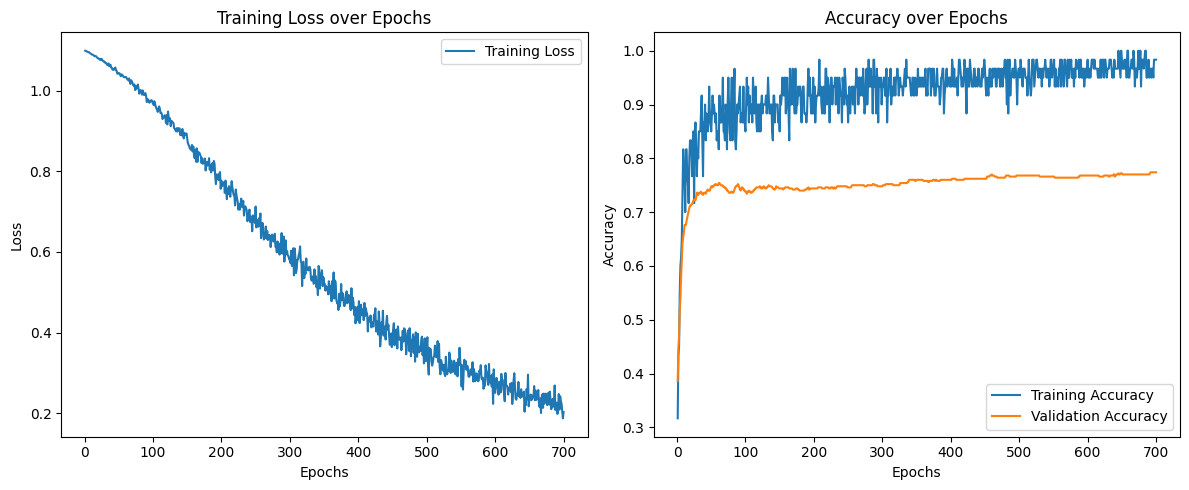

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

# Define the GCN model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Load the Pubmed dataset
path = './data/Pubmed'
transform = T.Compose([T.NormalizeFeatures()])
dataset = Planetoid(path, name='Pubmed', transform=transform)

# Extract the dataset details
data = dataset[0]
num_features = dataset.num_features
num_classes = dataset.num_classes

print(f'Number of features: {num_features}')
print(f'Number of classes: {num_classes}')

# Initialize the DataLoader
train_loader = DataLoader([data], batch_size=1, shuffle=True)
val_loader = DataLoader([data], batch_size=1, shuffle=False)


# Training and validation functions
def train(model, optimizer, train_loader, device, epoch, distillate=False, teacher=None):
    model.train()
    total_loss = 0
    correct = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[dataset.train_mask], data.y[dataset.train_mask])
        ##############################################################################################
        if distillate and teacher is not None:
            with torch.no_grad():
                teacher_out = teacher(data)
            loss += F.mse_loss(out[dataset.train_mask], teacher_out[dataset.train_mask])
        ##############################################################################################
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        pred = out[dataset.train_mask].argmax(dim=1)
        correct += pred.eq(data.y[dataset.train_mask]).sum().item()
    train_acc = correct / dataset.train_mask.sum().item()
    print(f'Epoch {epoch}, Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}')
    return total_loss / len(train_loader.dataset), train_acc

def validate(model, val_loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data)
            pred = out[dataset.val_mask].argmax(dim=1)
            correct += pred.eq(data.y[dataset.val_mask]).sum().item()
    val_acc = correct / dataset.val_mask.sum().item()
    print(f'Val Acc: {val_acc:.4f}')
    return val_acc

# Initialize the model and optimizer for Stage 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = GCN(num_features, num_hidden, num_classes).to(device)
optimizer = torch.optim.Adam(base_model.parameters(), lr=lr, weight_decay=1e-5)

# Training the base model for 200 epochs
train_losses = []
train_accuracies = []
val_accuracies = []

epochs = range(1, num_epochs_base+1)

for epoch in epochs:
    loss, train_acc = train(base_model, optimizer, train_loader, device, epoch)
    val_acc = validate(base_model, val_loader, device)
    train_losses.append(loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Plotting the training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


Stage 1: Real-valued and Real-weighted Network

In [3]:
train_losses1 = []
train_accuracies1 = []
val_accuracies1 = []
# Define the student model for Stage 1 (replace quantization with tanh)
class StudentGCNStage1(GCN):
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.tanh(x)  # Use tanh instead of ReLU
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the student model and optimizer for Stage 1
student_stage1 = StudentGCNStage1(num_features, num_hidden, num_classes).to(device)
student_stage1.load_state_dict(base_model.state_dict())  # Distill weights from base model
optimizer_stage1 = torch.optim.Adam(student_stage1.parameters(), lr=lr, weight_decay=1e-5)

# Training the student model for Stage 1
for epoch in epochs:
    loss, train_acc = train(student_stage1, optimizer_stage1, train_loader, device, epoch, distillate=True, teacher=base_model)
    val_acc = validate(student_stage1, val_loader, device)
    train_losses1.append(loss)
    train_accuracies1.append(train_acc)
    val_accuracies1.append(val_acc)
print(len(train_losses1))

Epoch 1, Loss: 0.6610, Train Acc: 0.9333
Val Acc: 0.7720
Epoch 2, Loss: 0.4917, Train Acc: 1.0000
Val Acc: 0.7700
Epoch 3, Loss: 0.4882, Train Acc: 1.0000
Val Acc: 0.7700
Epoch 4, Loss: 0.6488, Train Acc: 0.9833
Val Acc: 0.7700
Epoch 5, Loss: 0.5691, Train Acc: 0.9833
Val Acc: 0.7760
Epoch 6, Loss: 0.5354, Train Acc: 0.9833
Val Acc: 0.7800
Epoch 7, Loss: 0.5144, Train Acc: 0.9667
Val Acc: 0.7820
Epoch 8, Loss: 0.5133, Train Acc: 0.9833
Val Acc: 0.7820
Epoch 9, Loss: 0.6306, Train Acc: 0.9667
Val Acc: 0.7840
Epoch 10, Loss: 0.4958, Train Acc: 0.9500
Val Acc: 0.7820
Epoch 11, Loss: 0.4081, Train Acc: 0.9667
Val Acc: 0.7800
Epoch 12, Loss: 0.6132, Train Acc: 0.9833
Val Acc: 0.7820
Epoch 13, Loss: 0.4960, Train Acc: 0.9833
Val Acc: 0.7820
Epoch 14, Loss: 0.5191, Train Acc: 0.9833
Val Acc: 0.7820
Epoch 15, Loss: 0.6908, Train Acc: 0.9500
Val Acc: 0.7820
Epoch 16, Loss: 0.5930, Train Acc: 0.9667
Val Acc: 0.7840
Epoch 17, Loss: 0.5653, Train Acc: 0.9833
Val Acc: 0.7800
Epoch 18, Loss: 0.5791,

In [4]:
# Define rPReLU
class rPReLU(nn.Module):
    def __init__(self, num_parameters=1, init=0.25):
        super(rPReLU, self).__init__()
        self.weight = nn.Parameter(torch.full((num_parameters,), init))
        self.bias = nn.Parameter(torch.zeros(num_parameters))

    def forward(self, x):
        return torch.max(torch.zeros_like(x), x) + self.weight * torch.min(torch.zeros_like(x), x) + self.bias


# Define rSign
class rSign(nn.Module):
    def __init__(self, threshold=0.0):
        super(rSign, self).__init__()
        self.threshold = threshold

    def forward(self, x):
        return (x > self.threshold).float() * 2 - 1


In [5]:
# Define the student model for Stage 2 (using rPReLU for activations)
class StudentGCNStage2(GCN):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(StudentGCNStage2, self).__init__(in_channels, hidden_channels, out_channels)
        self.rprelu = rPReLU(hidden_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.rprelu(x)  # Use rPReLU activations
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the student model and optimizer for Stage 2
student_stage2 = StudentGCNStage2(num_features, num_hidden, num_classes).to(device)
student_stage2.load_state_dict(student_stage1.state_dict(), strict=False)  # Allow missing keys

# Manually initialize rPReLU parameters
with torch.no_grad():
    student_stage2.rprelu.weight.copy_(torch.full((num_hidden,), 0.25))
    student_stage2.rprelu.bias.copy_(torch.zeros(num_hidden))

optimizer_stage2 = torch.optim.Adam(student_stage2.parameters(), lr=lr*0.25, weight_decay=1e-5)  # Smaller learning rate

# Training the student model for Stage 2
train_losses2 = []
train_accuracies2 = []
val_accuracies2 = []

for epoch in epochs:
    loss, train_acc = train(student_stage2, optimizer_stage2, train_loader, device, epoch, distillate=True, teacher=student_stage1)
    val_acc = validate(student_stage2, val_loader, device)
    train_losses2.append(loss)
    train_accuracies2.append(train_acc)
    val_accuracies2.append(val_acc)


Epoch 1, Loss: 0.9494, Train Acc: 1.0000
Val Acc: 0.7820
Epoch 2, Loss: 0.9625, Train Acc: 1.0000
Val Acc: 0.7780
Epoch 3, Loss: 0.9298, Train Acc: 1.0000
Val Acc: 0.7780
Epoch 4, Loss: 1.0195, Train Acc: 1.0000
Val Acc: 0.7760
Epoch 5, Loss: 0.9032, Train Acc: 1.0000
Val Acc: 0.7760
Epoch 6, Loss: 1.0067, Train Acc: 0.9833
Val Acc: 0.7760
Epoch 7, Loss: 0.9799, Train Acc: 1.0000
Val Acc: 0.7740
Epoch 8, Loss: 0.9841, Train Acc: 1.0000
Val Acc: 0.7740
Epoch 9, Loss: 1.0134, Train Acc: 1.0000
Val Acc: 0.7740
Epoch 10, Loss: 0.8792, Train Acc: 1.0000
Val Acc: 0.7740
Epoch 11, Loss: 0.8803, Train Acc: 0.9833
Val Acc: 0.7720
Epoch 12, Loss: 0.9871, Train Acc: 1.0000
Val Acc: 0.7720
Epoch 13, Loss: 0.9559, Train Acc: 1.0000
Val Acc: 0.7740
Epoch 14, Loss: 0.9788, Train Acc: 0.9833
Val Acc: 0.7720
Epoch 15, Loss: 0.9467, Train Acc: 1.0000
Val Acc: 0.7720
Epoch 16, Loss: 0.9502, Train Acc: 1.0000
Val Acc: 0.7720
Epoch 17, Loss: 0.9079, Train Acc: 1.0000
Val Acc: 0.7720
Epoch 18, Loss: 0.8171,

Epoch 1, Loss: 0.3180, Train Acc: 1.0000
Val Acc: 0.7740
Epoch 2, Loss: 0.4056, Train Acc: 1.0000
Val Acc: 0.7720
Epoch 3, Loss: 0.3296, Train Acc: 1.0000
Val Acc: 0.7700
Epoch 4, Loss: 0.3593, Train Acc: 1.0000
Val Acc: 0.7720
Epoch 5, Loss: 0.2971, Train Acc: 1.0000
Val Acc: 0.7720
Epoch 6, Loss: 0.3115, Train Acc: 1.0000
Val Acc: 0.7720
Epoch 7, Loss: 0.3145, Train Acc: 1.0000
Val Acc: 0.7720
Epoch 8, Loss: 0.3111, Train Acc: 1.0000
Val Acc: 0.7720
Epoch 9, Loss: 0.3176, Train Acc: 1.0000
Val Acc: 0.7720
Epoch 10, Loss: 0.3782, Train Acc: 1.0000
Val Acc: 0.7720
Epoch 11, Loss: 0.3432, Train Acc: 1.0000
Val Acc: 0.7720
Epoch 12, Loss: 0.3334, Train Acc: 1.0000
Val Acc: 0.7720
Epoch 13, Loss: 0.3613, Train Acc: 1.0000
Val Acc: 0.7740
Epoch 14, Loss: 0.3732, Train Acc: 1.0000
Val Acc: 0.7740
Epoch 15, Loss: 0.3632, Train Acc: 1.0000
Val Acc: 0.7740
Epoch 16, Loss: 0.3458, Train Acc: 1.0000
Val Acc: 0.7740
Epoch 17, Loss: 0.3896, Train Acc: 1.0000
Val Acc: 0.7740
Epoch 18, Loss: 0.3164,

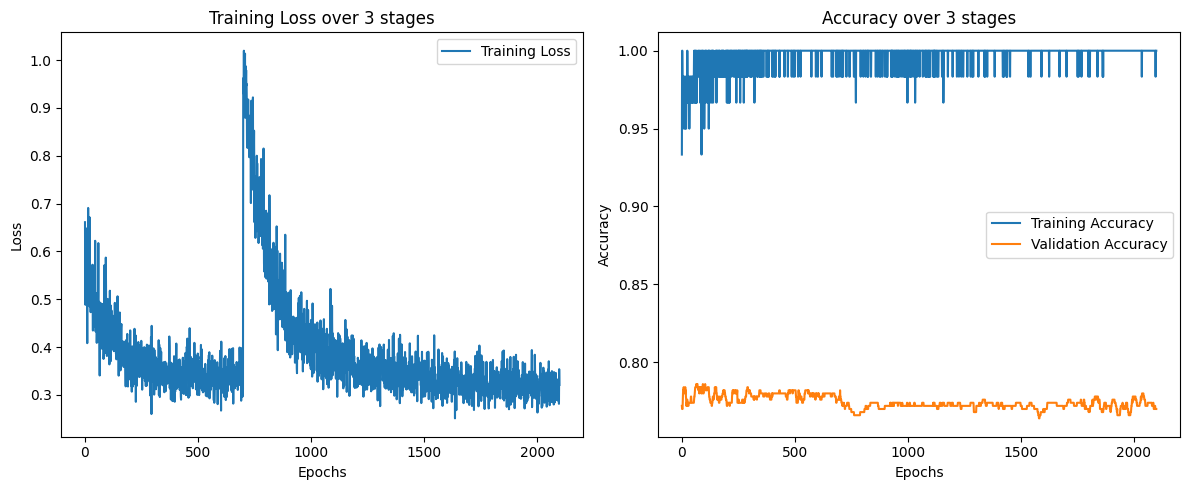

In [6]:
import matplotlib.pyplot as plt

# Define custom GCNConv layer to handle latent weights
class BinaryGCNConv(GCNConv):
    def __init__(self, in_channels, out_channels):
        super(BinaryGCNConv, self).__init__(in_channels, out_channels)
        self.latent_weight = nn.Parameter(torch.empty(self.out_channels, self.in_channels))
        nn.init.xavier_uniform_(self.latent_weight)  # Initialize weights explicitly

    def forward(self, x, edge_index, edge_weight=None):
        weight_bin = rSign()(self.latent_weight)  # Use rSign for binarization
        self.weight = nn.Parameter(weight_bin)  # Assign the binary weights to self.weight
        return super(BinaryGCNConv, self).forward(x, edge_index, edge_weight)  # Call the parent forward method

    def message(self, x_j, edge_weight):
        if edge_weight is None:
            return x_j
        else:
            return edge_weight.view(-1, 1) * x_j

# Define the custom GCN model with binary weights and rSign activations
class BinaryGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(BinaryGCN, self).__init__()
        self.conv1 = BinaryGCNConv(in_channels, hidden_channels)
        self.conv2 = BinaryGCNConv(hidden_channels, out_channels)
        self.rprelu = rPReLU(hidden_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.rprelu(x)  # Use rPReLU activations
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the student model and optimizer for Stage 3
student_stage3 = BinaryGCN(num_features, num_hidden, num_classes).to(device)
student_stage3.load_state_dict(student_stage2.state_dict(), strict=False)  # Allow missing keys

# Manually update latent_weight for each BinaryGCNConv layer
with torch.no_grad():
    student_stage3.conv1.latent_weight.copy_(student_stage3.conv1.lin.weight.clone().detach())
    student_stage3.conv2.latent_weight.copy_(student_stage3.conv2.lin.weight.clone().detach())

optimizer_stage3 = torch.optim.Adam(student_stage3.parameters(), lr=lr*0.25, weight_decay=0)  # No weight decay

# Training the student model for Stage 3
train_losses3 = []
train_accuracies3 = []
val_accuracies3 = []

for epoch in epochs:
    loss, train_acc = train(student_stage3, optimizer_stage3, train_loader, device, epoch, distillate=True, teacher=student_stage2)
    val_acc = validate(student_stage3, val_loader, device)
    train_losses3.append(loss)
    train_accuracies3.append(train_acc)
    val_accuracies3.append(val_acc)



# Combine all epochs into one list
total_epochs = 3 * num_epochs_base
print(len(train_losses1))
print(len(train_losses2))
print(len(train_losses3))
print(len(train_losses))
# Ensure lengths of the lists match
train_losses = train_losses1 + train_losses2 + train_losses3
train_accuracies = train_accuracies1 + train_accuracies2 + train_accuracies3
val_accuracies = val_accuracies1 + val_accuracies2 + val_accuracies3

plt.figure(figsize=(12, 5))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over 3 stages')
plt.legend()

# Plot the accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over 3 stages')
plt.legend()

plt.tight_layout()
plt.show()


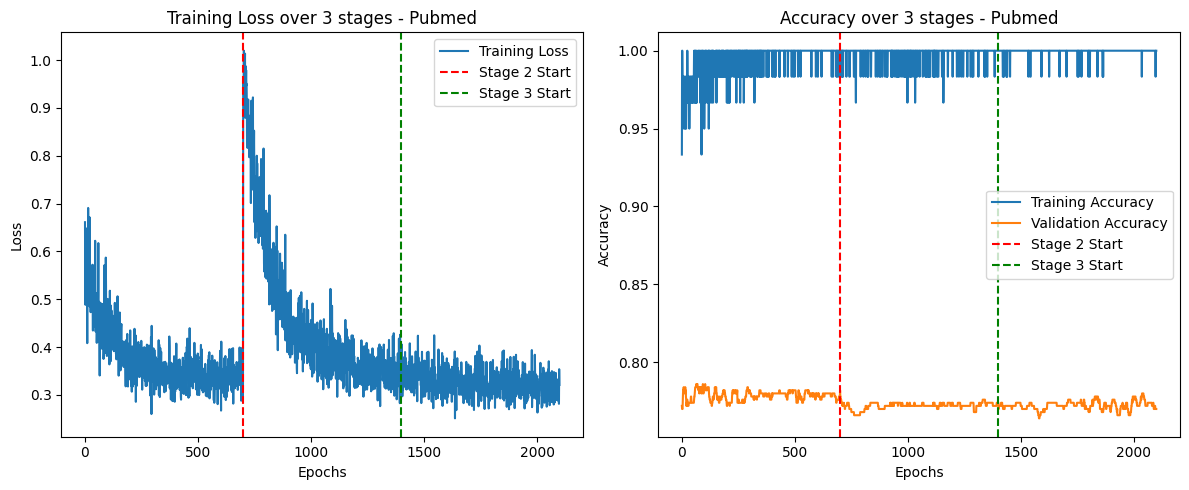

In [9]:
plt.figure(figsize=(12, 5))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.axvline(x=700, color='r', linestyle='--', label='Stage 2 Start')
plt.axvline(x=1400, color='g', linestyle='--', label='Stage 3 Start')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over 3 stages - Pubmed')
plt.legend()

# Plot the accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.axvline(x=700, color='r', linestyle='--', label='Stage 2 Start')
plt.axvline(x=1400, color='g', linestyle='--', label='Stage 3 Start')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over 3 stages - Pubmed')
plt.legend()

plt.tight_layout()
plt.savefig("3stage_withReAct.png")